In [1]:
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/ #copying kaggle.json
! chmod 600 ~/.kaggle/kaggle.json #reading the file with full access
# make sure kaggle.json file is present
! ls -lha kaggle.json

! pip install -q kaggle

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 65 Feb  4 11:14 kaggle.json


In [ ]:
! kaggle datasets download -d mbornoe/lisa-traffic-light-dataset
! mkdir data
! unzip lisa-traffic-light-dataset.zip -d ./data

In [3]:
from time import time
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

import os
import datetime


In [4]:
torch.cuda.empty_cache() 

In [5]:
DATA_PATH = './data'
DAY_TRAIN_PATH = './data/Annotations/Annotations/dayTrain/'
NIGHT_TRAIN_PATH = './data/Annotations/Annotations/nightTrain/'

EPOCHS = 2
BATCH_SIZE = 8
WORKERS = 2

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Combining annotations of both day and night clips into one csv.

In [6]:
train_day = []
for clipName in tqdm(sorted(os.listdir(DAY_TRAIN_PATH))):
    if 'dayClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(DAY_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_day.append(df)
    
train_day_df = pd.concat(train_day,axis=0)
train_day_df['isNight'] = 0
    
train_night = []
for clipName in tqdm(sorted(os.listdir(NIGHT_TRAIN_PATH))):
    if 'nightClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(NIGHT_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_night.append(df)

train_night_df = pd.concat(train_night,axis=0)
train_night_df['isNight'] = 1

df = pd.concat([train_day_df,train_night_df],axis=0)

100%|██████████| 5/5 [00:00<00:00, 107.28it/s]


In [7]:
df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number,isNight
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,0


In [8]:
# Droppin duplicate columns & "Origin file" as we don't need it
df = df.drop(['Origin file','Origin track','Origin track frame number'],axis=1)

In [9]:
# Here Filename (Location of Image) is different -> Change it to appropriate name
# Ex. dayTraining/dayClip1--00000.jpg -> dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg

def changeFilename(x):
    filename = x.Filename
    isNight = x.isNight
    
    splitted = filename.split('/')
    clipName = splitted[-1].split('--')[0]
    if isNight:
        return os.path.join(DATA_PATH,f'nightTrain/nightTrain/{clipName}/frames/{splitted[-1]}')
    else:
        return os.path.join(DATA_PATH,f'dayTrain/dayTrain/{clipName}/frames/{splitted[-1]}')

df['Filename'] = df.apply(changeFilename,axis=1)

In [10]:
df['Annotation tag'].unique()

array(['go', 'stop', 'stopLeft', 'warning', 'goLeft', 'warningLeft'],
      dtype=object)

In [11]:
# We will change annotations to only -> stop (RED), go (GREEN) & warning (YELLOW)
label_to_idx = {'go':1, 'warning':2, 'stop': 3}
idx_to_label = {v:k for k,v in label_to_idx.items()}

def changeAnnotation(x):
    if 'go' in x['Annotation tag']:
        return label_to_idx['go']
    elif 'warning' in x['Annotation tag']:
        return label_to_idx['warning']
    elif 'stop' in x['Annotation tag']:
        return label_to_idx['stop']
    
df['Annotation tag'] = df.apply(changeAnnotation,axis=1)

annotation_tags = df['Annotation tag'].unique()
annotation_tags

array([1, 3, 2])

In [12]:
df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin frame number,isNight
0,./data/dayTrain/dayTrain/dayClip1/frames/dayCl...,1,698,333,710,358,0,0
1,./data/dayTrain/dayTrain/dayClip1/frames/dayCl...,1,846,391,858,411,0,0
2,./data/dayTrain/dayTrain/dayClip1/frames/dayCl...,1,698,337,710,357,1,0
3,./data/dayTrain/dayTrain/dayClip1/frames/dayCl...,1,847,390,859,410,1,0
4,./data/dayTrain/dayTrain/dayClip1/frames/dayCl...,1,698,331,710,356,2,0


In [13]:
df['Annotation tag'].unique()

array([1, 3, 2])

In [14]:
# Changing Column Names
df.columns = ['image_id','label','x_min','y_min','x_max','y_max','frame','isNight']

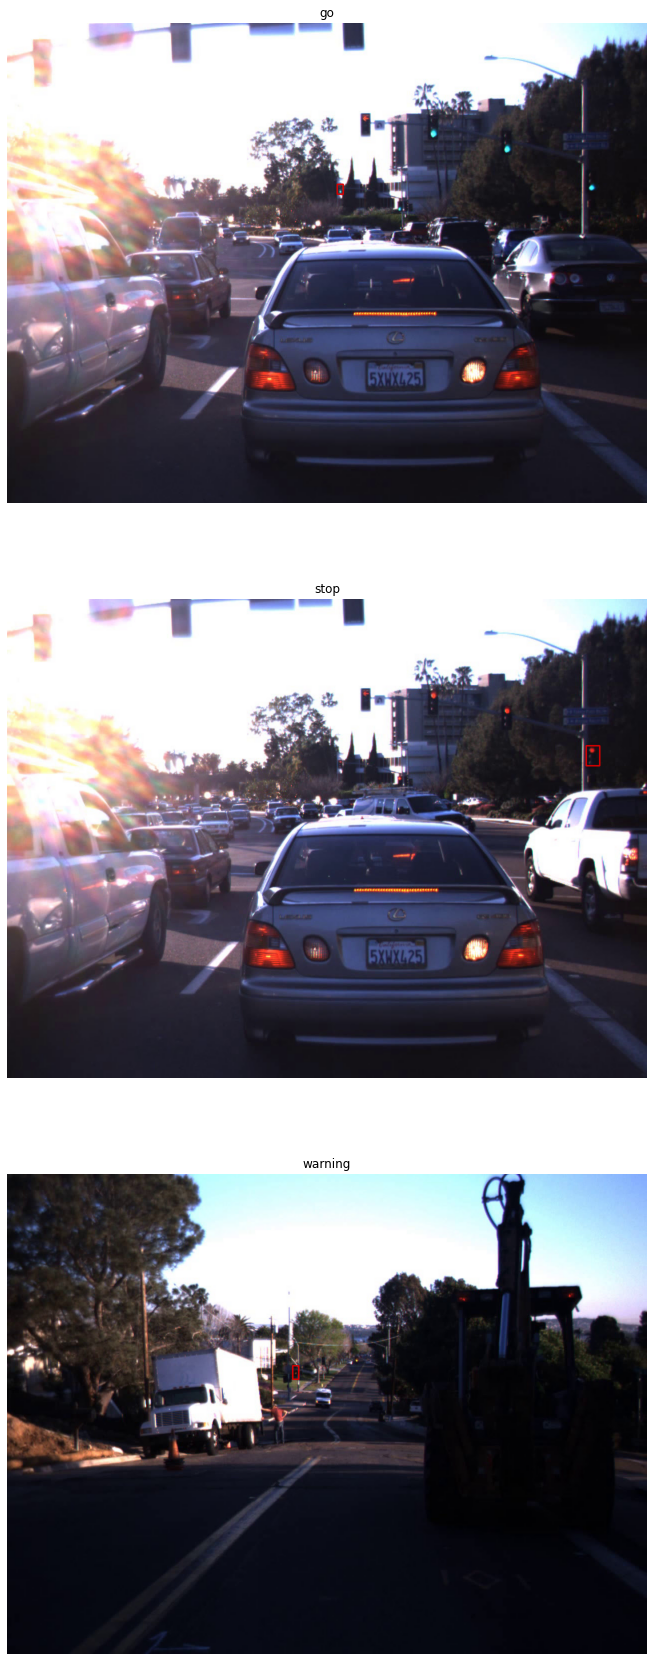

In [15]:
fig, ax = plt.subplots(len(annotation_tags),1,figsize=(15,10*len(annotation_tags)))

for i, tag in enumerate(annotation_tags):
    sample = df[df['label']==tag].sample(1)
    bbox = sample[['x_min','y_min','x_max','y_max']].values[0]
    
    image = cv2.imread(sample.image_id.values[0])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(220, 0, 0), 2)
    
    ax[i].set_title(idx_to_label[tag])
    ax[i].set_axis_off()
    ax[i].imshow(image)

In [16]:
df['clipNames'] = df[['image_id']].applymap(lambda x: x.split('/')[4])
df['clipNames'].unique()

array(['dayClip1', 'dayClip10', 'dayClip11', 'dayClip12', 'dayClip13',
       'dayClip2', 'dayClip3', 'dayClip4', 'dayClip5', 'dayClip6',
       'dayClip7', 'dayClip8', 'dayClip9', 'nightClip1', 'nightClip2',
       'nightClip3', 'nightClip4', 'nightClip5'], dtype=object)

In [17]:
def split(df,p=0.25):
    clipNames = sorted(df['clipNames'].unique())

    nightClips = [name for name in clipNames if 'night' in name]
    dayClips = [name for name in clipNames if 'day' in name]

    # random test names
    testNightClipNames = list(np.random.choice(nightClips,int(len(nightClips)*p)))
    testDayClipNames = list(np.random.choice(dayClips,int(len(dayClips)*p)))
    testClipNames = testNightClipNames + testDayClipNames

    # train clips
    trainDayClipNames = list(set(dayClips) - set(testDayClipNames))
    trainNightClipNames = list(set(nightClips) - set(testNightClipNames))
    trainClipNames = trainNightClipNames + trainDayClipNames
    
    train_df = df[df.clipNames.isin(trainClipNames)]
    test_df = df[df.clipNames.isin(testClipNames)]
    
    return train_df, test_df

In [18]:
train_df, test_df = split(df)

In [19]:
train_df, val_df = split(train_df)
train_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,./data/dayTrain/dayTrain/dayClip1/frames/dayCl...,1,698,333,710,358,0,0,dayClip1
1,./data/dayTrain/dayTrain/dayClip1/frames/dayCl...,1,846,391,858,411,0,0,dayClip1
2,./data/dayTrain/dayTrain/dayClip1/frames/dayCl...,1,698,337,710,357,1,0,dayClip1
3,./data/dayTrain/dayTrain/dayClip1/frames/dayCl...,1,847,390,859,410,1,0,dayClip1
4,./data/dayTrain/dayTrain/dayClip1/frames/dayCl...,1,698,331,710,356,2,0,dayClip1


In [20]:
class TrafficLightsDataset:
    def __init__(self, df, transforms=None):
        super().__init__()

        # Image_ids will be the "Filename" here
        self.image_ids = df.image_id.unique()
        self.df = df
        self.transforms = transforms
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df.image_id == image_id]

        # Reading Image
        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # Bounding Boxes
        boxes = records[['x_min','y_min','x_max','y_max']].values
        boxes = torch.as_tensor(boxes,dtype=torch.float32)
        
        # Area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Labels of the object detected
        labels = torch.as_tensor(records.label.values, dtype=torch.int64)
        
        iscrowd = torch.zeros_like(labels, dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            # target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            target['boxes'] = torch.as_tensor(sample['bboxes'],dtype=torch.float32)
            target['labels'] = torch.as_tensor(sample['labels'])
            
        return image, target, image_id

In [21]:
class LossAverager:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [22]:
# Custom Batching with no collate function your batch data would look like:
# [(img_0, targets_0), (img_1, targets_1), ...]
# but with the collate function it would be more like
# [(img_0, img_1), (targets_0, targets_1), ...]

def collate_fn(batch):
    return tuple(zip(*batch))

In [23]:
# Albumentations

# For Train Data
def getTrainTransform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# For Validation Data
def getValTransform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# For Test Data
def getTestTransform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

It takes too much time to train. So we will only train on 10000 images.

In [24]:
trainDataset = TrafficLightsDataset(train_df[:10000],getTrainTransform())
valDataset = TrafficLightsDataset(val_df[:1000],getValTransform())
testDataset = TrafficLightsDataset(test_df[:1000],getTestTransform())

In [25]:
trainDataLoader = DataLoader(
    trainDataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS,
    collate_fn=collate_fn
)

valDataLoader = DataLoader(
    valDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    collate_fn=collate_fn
)

testDataLoader = DataLoader(
    testDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    collate_fn=collate_fn
)

In [26]:
images, targets, image_ids = next(iter(trainDataLoader))

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
image = images[0].permute(1,2,0).cpu().numpy()

In [27]:
def displayImage(image, boxes):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()

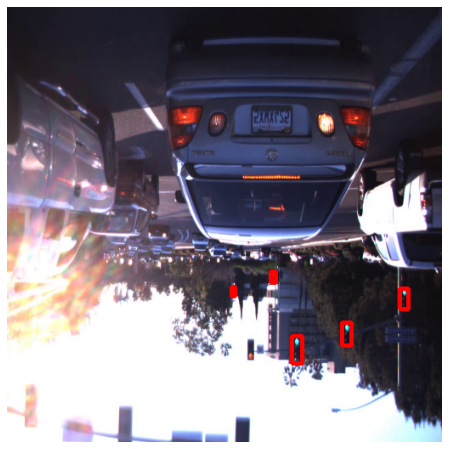

In [28]:
displayImage(image,boxes)

In [29]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

N_CLASS = 4  # 3 classes (Stop, Warning, Go) + Background

# Number of Input Features for the Classifier Head
INP_FEATURES = model.roi_heads.box_predictor.cls_score.in_features

# New Head for Classification
model.roi_heads.box_predictor = FastRCNNPredictor(INP_FEATURES, N_CLASS)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [30]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
# Optimizers
optimizer = torch.optim.Adam(params)

# LR Scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [31]:
lossHist = LossAverager()
valLossHist = LossAverager()

for epoch in range(EPOCHS):
    
    start_time = time()
    model.train()
    lossHist.reset()
    
    for images, targets, image_ids in tqdm(trainDataLoader):
        
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        bs = images.shape[0]
        
        loss_dict = model(images, targets)
        
        totalLoss = sum(loss for loss in loss_dict.values())
        lossValue = totalLoss.item()
        
        lossHist.update(lossValue,bs)

        optimizer.zero_grad()
        totalLoss.backward()
        optimizer.step()
    
    # LR Update
    if lr_scheduler is not None:
        lr_scheduler.step(totalLoss)

    print(f"[{str(datetime.timedelta(seconds = time() - start_time))[2:7]}]")
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"Train loss: {lossHist.avg}")
    
    torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

100%|██████████| 361/361 [08:55<00:00,  1.48s/it]


[08:55]
Epoch 0/2
Train loss: 0.7601528041860433


100%|██████████| 361/361 [08:49<00:00,  1.47s/it]


[08:49]
Epoch 1/2
Train loss: 0.15980709772996202


In [32]:
model.load_state_dict(torch.load('fasterrcnn_resnet50_fpn.pth'))

<All keys matched successfully>

In [33]:
model.eval()
images, targets, image_ids = next(iter(testDataLoader))
images = torch.stack(images).to(device)

outputs = model(images)

In [34]:
def filterBoxes(output,nms_th=0.3,score_threshold=0.5):
    
    boxes = output['boxes']
    scores = output['scores']
    labels = output['labels']
    
    # Non Max Supression
    mask = nms(boxes,scores,nms_th)
    
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    boxes = boxes.data.cpu().numpy().astype(np.int32)
    scores = scores.data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    
    mask = scores >= score_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    return boxes, scores, labels

In [35]:
def displayPredictions(image_id,output,nms_th=0.3,score_threshold=0.5):
    
    boxes,scores,labels = filterBoxes(output,nms_th,score_threshold)
    
    # Preprocessing
    image = cv2.imread(image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = cv2.resize(image,(512,512))
    image /= 255.0
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    colors = {1:(0,255,0), 2:(255,255,0), 3:(255,0,0)}
    
    for box,label in zip(boxes,labels):
        image = cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      colors[label], 2)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()

Result will greatly improve if we used fulll data and trained for more epochs.

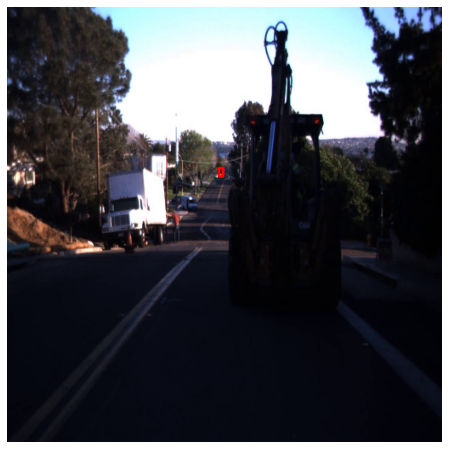

In [51]:
displayPredictions(image_ids[3],outputs[3],0.2,0.4)